In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats

In [2]:
temperatures = pd.read_csv("clean_data2.csv", header = 0, index_col = 0)

In [3]:
temperatures

day  month  year  tmax  tmin                   city        date
0       19     10  2020  25.8  18.4         AEROPARQUEAERO  2020-10-19
1       19     10  2020  23.9  11.9               AZULAERO  2020-10-19
2       19     10  2020  21.0  10.7        BAHIABLANCAAERO  2020-10-19
3       19     10  2020  -5.7 -11.8  BASECARLINI(EXJUBANY)  2020-10-19
5       19     10  2020  -3.0  -9.4            BASEORCADAS  2020-10-19
...    ...    ...   ...   ...   ...                    ...         ...
42970   21     10  2019  23.1   9.6          SANTAROSAAERO  2019-10-21
42973   21     10  2019  19.0   9.6             TANDILAERO  2019-10-21
42974   21     10  2019  30.0   8.5              TINOGASTA  2019-10-21
42979   21     10  2019  20.8   8.5             VIEDMAAERO  2019-10-21
42980   21     10  2019  27.0   4.6      VILLAREYNOLDSAERO  2019-10-21

[24820 rows x 7 columns]

In [4]:
city_list = list(temperatures["city"].unique())
aeroparque_ori = temperatures[temperatures["city"] == city_list[0]]
aeroparque_ori

day  month  year  tmax  tmin            city        date
0       19     10  2020  25.8  18.4  AEROPARQUEAERO  2020-10-19
93      18     10  2020  28.5  19.8  AEROPARQUEAERO  2020-10-18
186     17     10  2020  22.2  18.5  AEROPARQUEAERO  2020-10-17
288     16     10  2020  21.6  16.3  AEROPARQUEAERO  2020-10-16
382     15     10  2020  21.4  12.6  AEROPARQUEAERO  2020-10-15
...    ...    ...   ...   ...   ...             ...         ...
36383   15      5  2020  21.5   9.8  AEROPARQUEAERO  2020-05-15
36479   14      5  2020  14.1   7.9  AEROPARQUEAERO  2020-05-14
36643   12      5  2020  16.5   9.8  AEROPARQUEAERO  2020-05-12
36943    8      5  2020  18.3   9.8  AEROPARQUEAERO  2020-05-08
37145    6      5  2020  15.6   9.0  AEROPARQUEAERO  2020-05-06

[365 rows x 7 columns]

CREATING A GRAPH TO VISUALIZE THE DATA FOR ALL THE CITIES

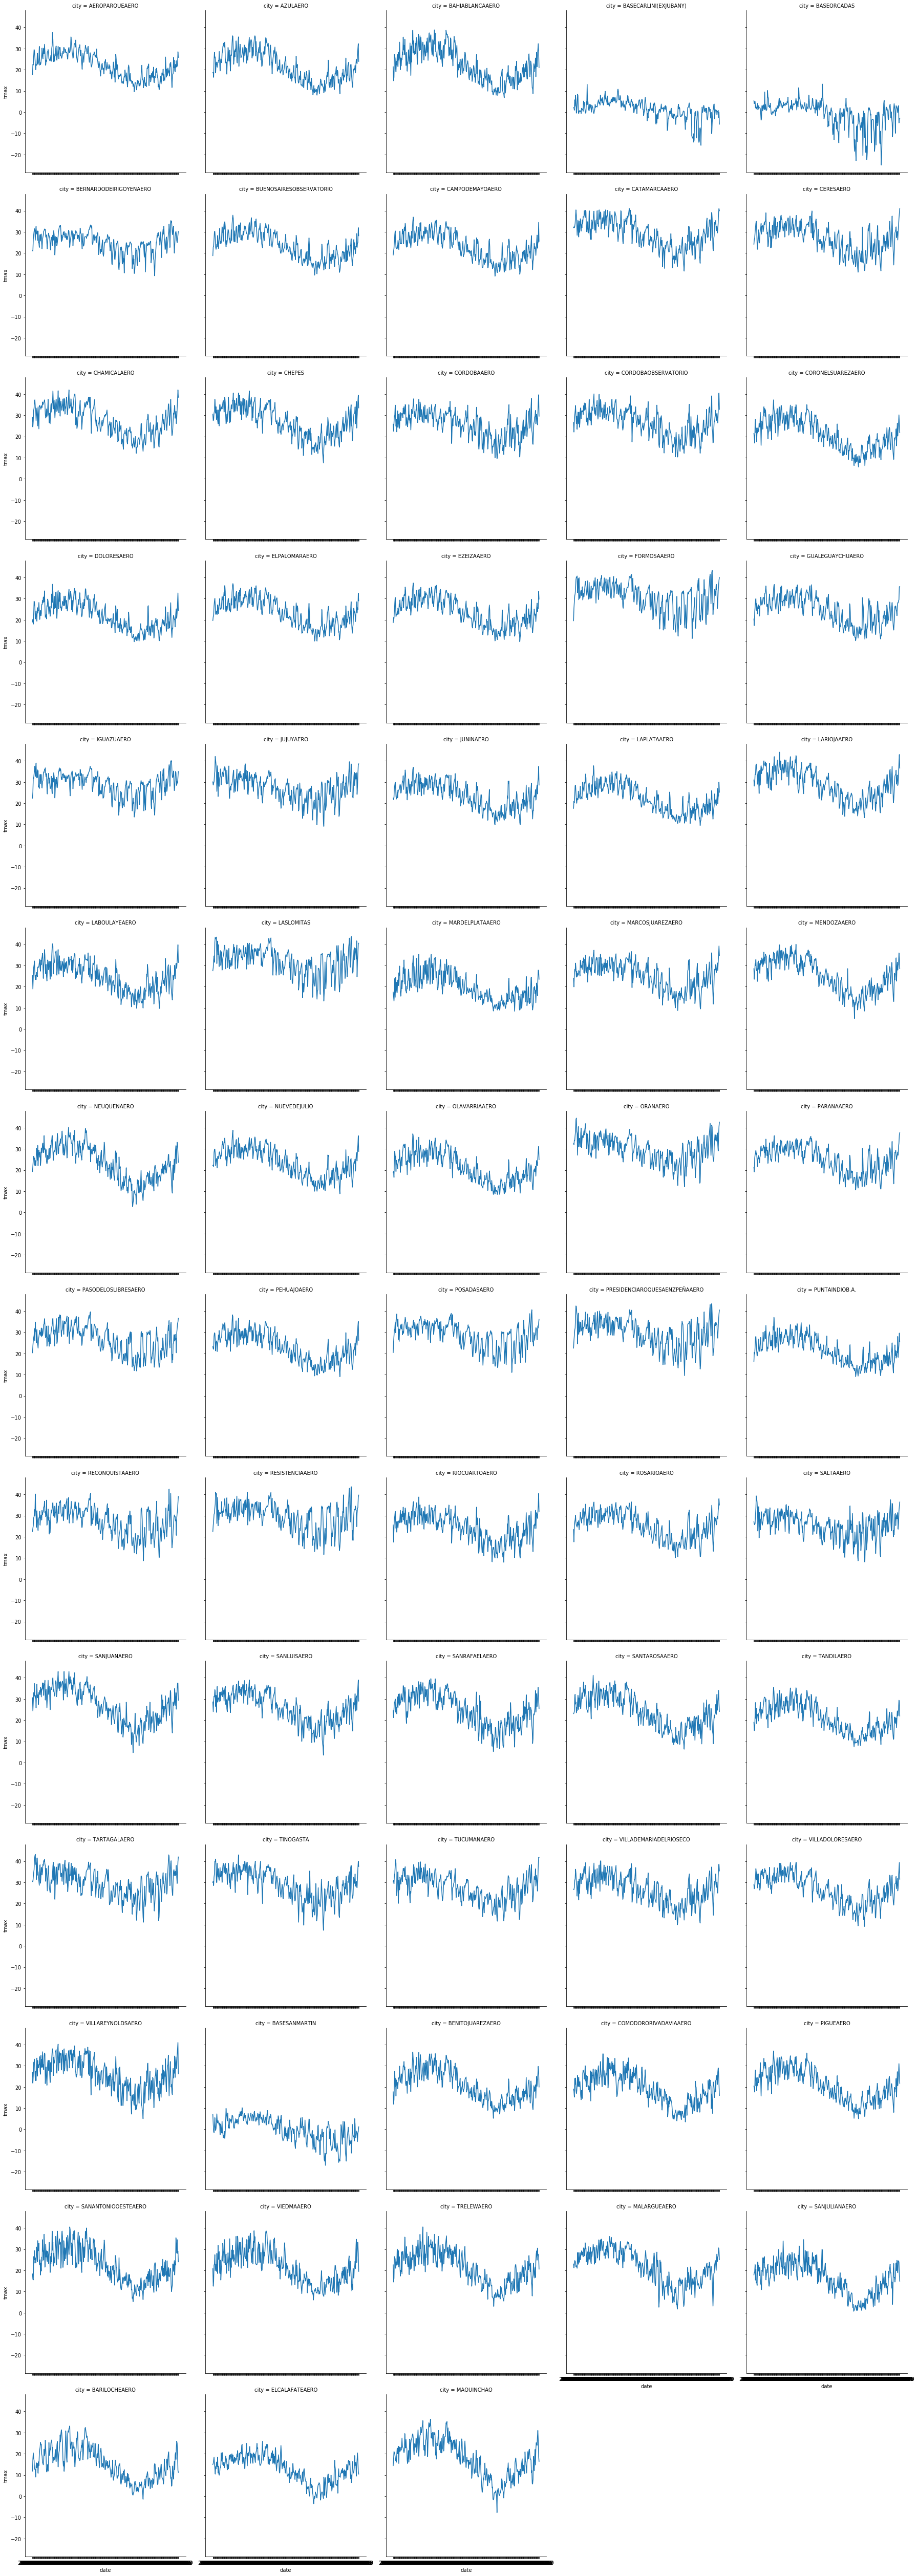

In [5]:
all_cities = sns.relplot(x="date", y="tmax", kind="line", col_wrap = 5 ,col = "city", data=temperatures)

Creating the time series plot for Aeroparque's data

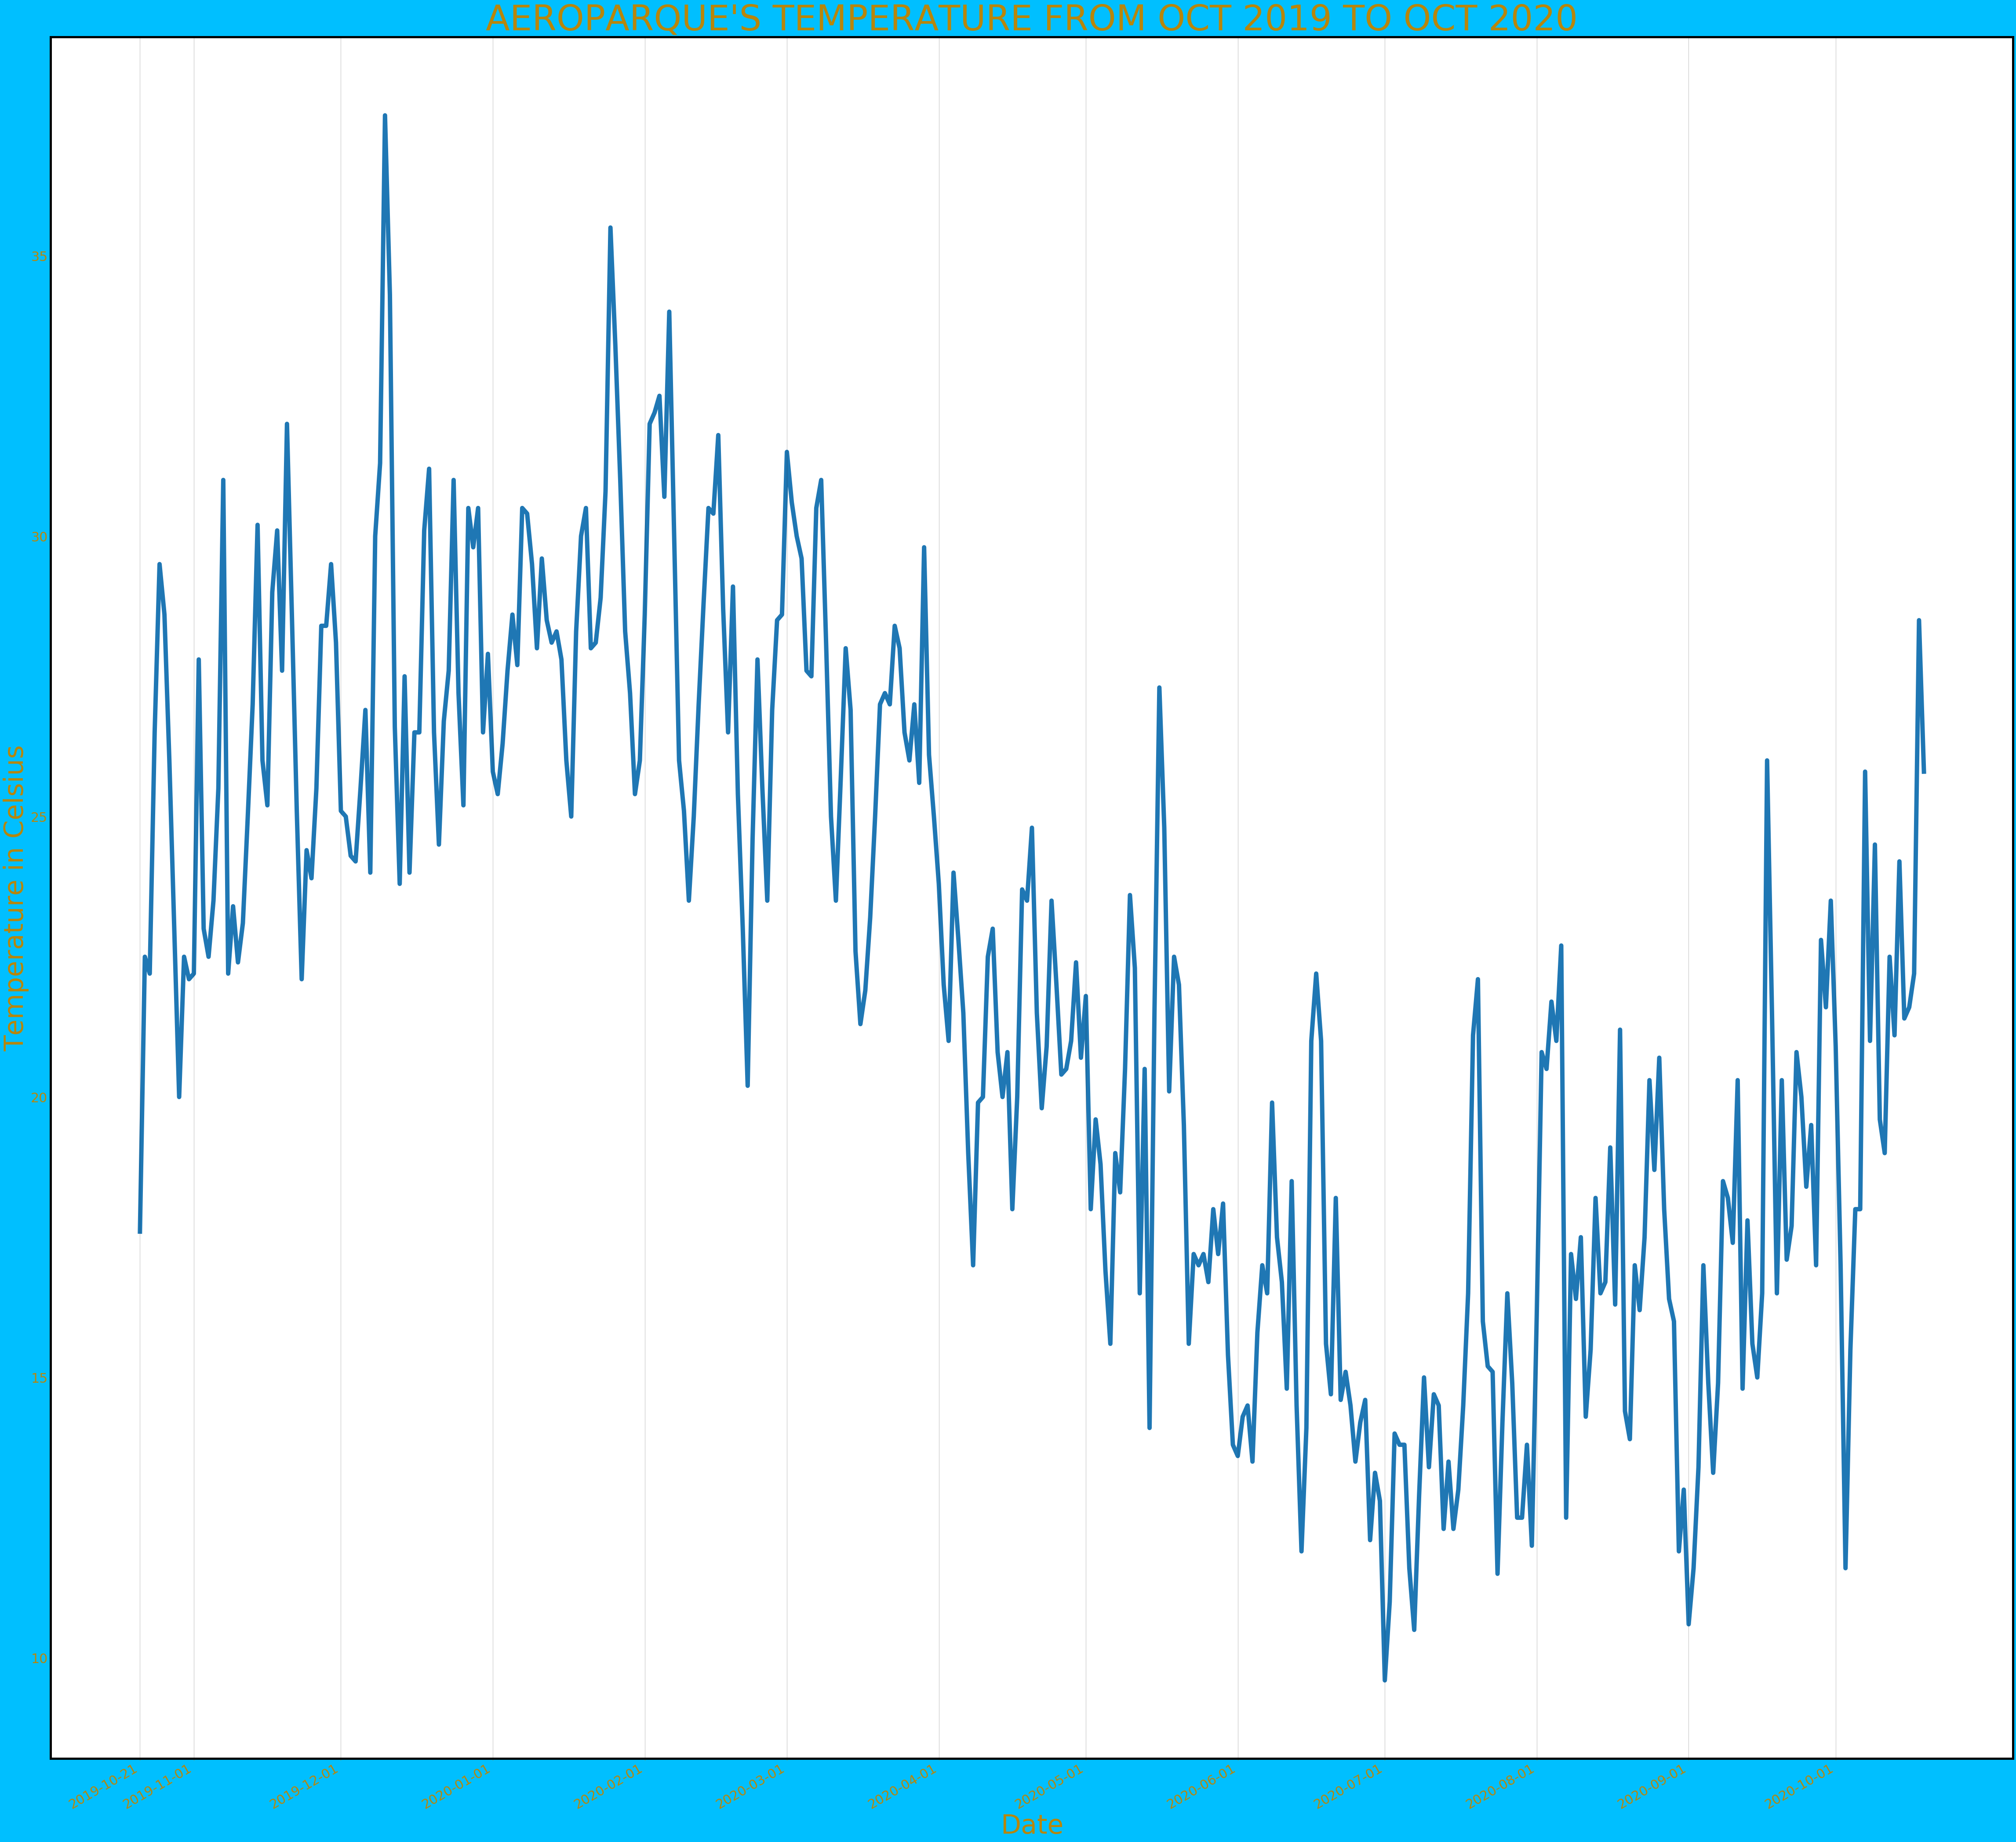

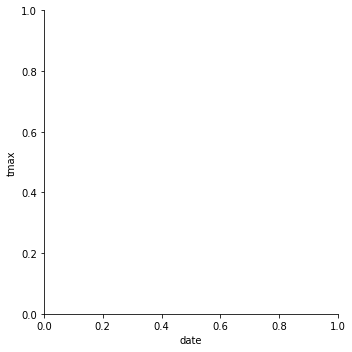

In [9]:
aerograph, aero_ax = plt.subplots(1, facecolor = "deepskyblue")
sns.relplot(x="date", y="tmax", kind="line", ci = "sd", linewidth = 10, data=aeroparque_ori, ax = aero_ax)
aerograph.set_figheight(80)
aerograph.set_figwidth(80)
aero_ax.set_title("AEROPARQUE'S TEMPERATURE FROM OCT 2019 TO OCT 2020", 
                  fontsize = 80,
                 color = "darkgoldenrod")
aero_ax.set_ylabel("Temperature in Celsius",
                  fontsize = 60,
                  color = "darkgoldenrod")
aero_ax.set_xlabel("Date",
                  fontsize = 60,
                  color = "darkgoldenrod")
aero_ax.tick_params(axis='y', which='major', colors = "darkgoldenrod", labelsize=30)
aero_ax.set_xticks([0,11,41,72,103,132,163,193,224,254,285,316,346])
tick_locations = [0,11,41,72,103,132,163,193,224,254,285,316,346]
for i in tick_locations:
    aero_ax.axvline(x=i, lw = 0.5, alpha = 0.5, color = "k")
aero_ax.tick_params(axis='x', which='major', labelsize=30, colors = "darkgoldenrod")
for side in aero_ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
    aero_ax.spines[side].set_linewidth(5)
aerograph.autofmt_xdate()

Based on the graph, we see that the temperatures in this locality had an upward trend from October 2019 to January 2020. Then, around March 2020 they started to decrease, and the trend continued until July, when they rose again.

Now, we prepare the data for the Dickey-Fuller test, the KPSS test, and for the correlogram without any processes

In [7]:
aeroparque_ori = aeroparque_ori.sort_values(by = "date")

In [8]:
aeroparque_ori

day  month  year  tmax  tmin            city        date
24913   21     10  2019  17.6  13.4  AEROPARQUEAERO  2019-10-21
24866   22     10  2019  22.5  12.4  AEROPARQUEAERO  2019-10-22
24815   23     10  2019  22.2  12.7  AEROPARQUEAERO  2019-10-23
24761   24     10  2019  26.5  12.6  AEROPARQUEAERO  2019-10-24
24675   25     10  2019  29.5  16.8  AEROPARQUEAERO  2019-10-25
...    ...    ...   ...   ...   ...             ...         ...
382     15     10  2020  21.4  12.6  AEROPARQUEAERO  2020-10-15
288     16     10  2020  21.6  16.3  AEROPARQUEAERO  2020-10-16
186     17     10  2020  22.2  18.5  AEROPARQUEAERO  2020-10-17
93      18     10  2020  28.5  19.8  AEROPARQUEAERO  2020-10-18
0       19     10  2020  25.8  18.4  AEROPARQUEAERO  2020-10-19

[365 rows x 7 columns]

In [10]:
#DF TEST
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression = "c")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    return dfoutput
aero_adf = adf_test(aeroparque_ori["tmax"])
print(aero_adf)

Results of Dickey-Fuller Test:
Test Statistic                  -1.315684
p-value                          0.621967
#Lags Used                      10.000000
Number of Observations Used    354.000000
Critical Value (1%)             -3.448958
Critical Value (5%)             -2.869739
Critical Value (10%)            -2.571138
dtype: float64


In [11]:
#KPSS TEST
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', lags='auto')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    return kpss_output
aero_kpss = kpss_test(aeroparque_ori["tmax"])
print(aero_kpss)

Results of KPSS Test:
Test Statistic            2.24868
p-value                   0.01000
Lags Used                11.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


C:\Users\Jesus\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


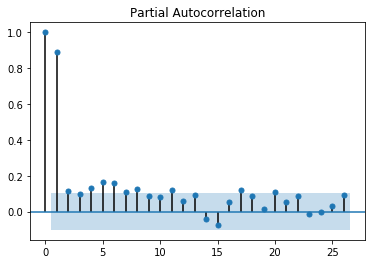

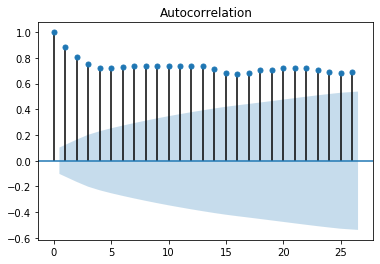

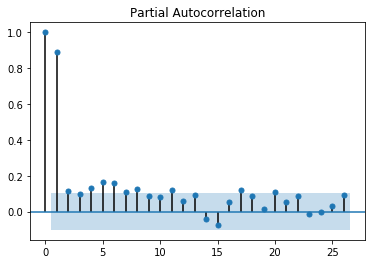

In [12]:
#Correlogram without differences
plot_acf(aeroparque_ori["tmax"])
plot_pacf(aeroparque_ori["tmax"])

ANALYSIS OF THE PREVIOUS RESULTS:

1- ADF TEST: 

   @Based on the p-value and the hypotheses of the test, we do not find enough evidence to reject the possibility that there is a unit-root problem in the time series data. 
    
   @However, this only applies after a lag level of 10. That is, that for lag levels from 1 up to 10, we are not going to find the unit-root problem. 

2- KPSS TEST: 
   
   @Based on the p-value and the hypotheses of the test, we can reject the null and affirm that there is indeed a unit root problem in the data. Still, it only occurs around a lag level of 11.

3- Correlogram:
    
   @Looking at both Partial and Total Autocorrelation graphs, we see that for the first lags the values are outside the bands. This suggest that we should apply differencing to the data.
   
Overall, the best course of action is to apply differencing

APPLYING DIFFERENCES, AND LOOKING AT THE GRAPHS FOR THE FIRST DIFFERENCES

In [13]:
aeroparque_diff = np.diff(aeroparque_ori["tmax"], n =1)

In [14]:
len(aeroparque_diff)

364

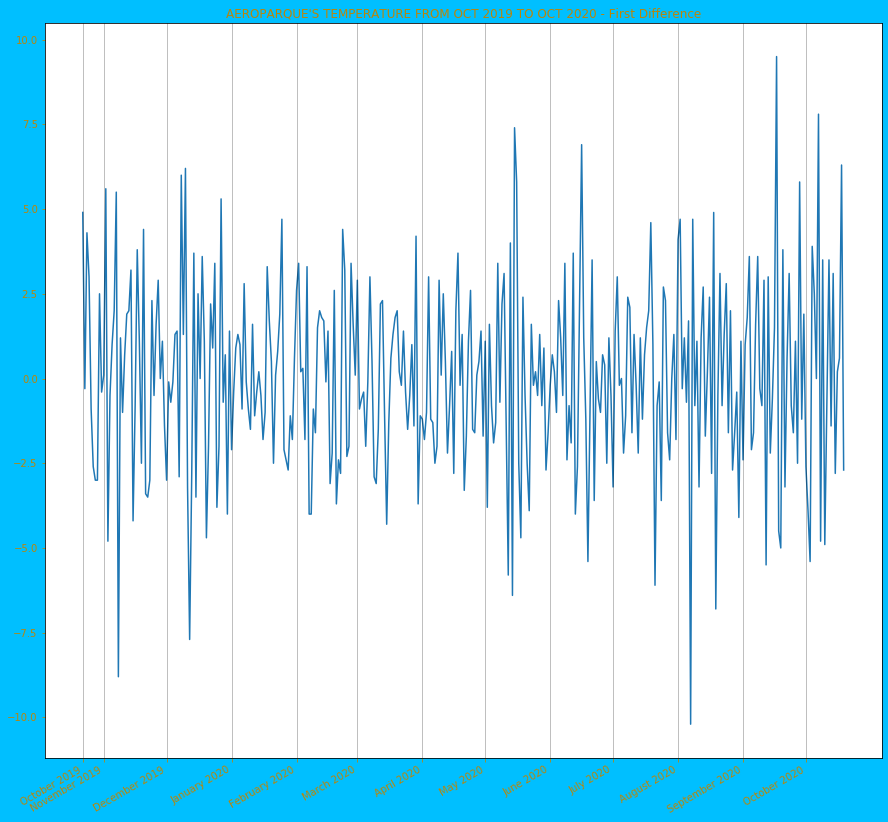

In [15]:
#Graph for the differences
aerograph_diff, aero_axd = plt.subplots(1, facecolor = "deepskyblue")
aero_axd.plot(aeroparque_diff)
aerograph_diff.set_figheight(15)
aerograph_diff.set_figwidth(15)
aero_axd.set_title("AEROPARQUE'S TEMPERATURE FROM OCT 2019 TO OCT 2020 - First Difference", 
                 color = "darkgoldenrod")
aero_axd.tick_params(axis='y', which='major', colors = "darkgoldenrod")
aero_axd.tick_params(axis='x', which='major', colors = "darkgoldenrod")
aero_axd.set_xticks([0,10,40,71,102,131,162,192,223,253,284,315,345])
aero_axd.set_xticklabels(["October 2019", "November 2019", "December 2019", "January 2020", "February 2020", "March 2020", "April 2020", "May 2020", "June 2020", "July 2020", "August 2020", "September 2020", "October 2020"])
tickd_locations = [0,10,40,71,102,131,162,192,223,253,284,315,345]
for i in tickd_locations:
    aero_axd.axvline(x=i, lw = 0.5, alpha = 0.5, color = "k")
aerograph_diff.autofmt_xdate()


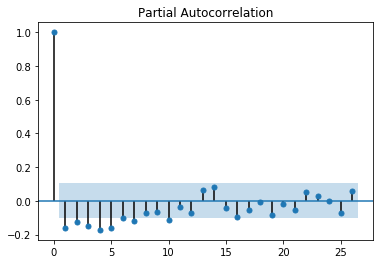

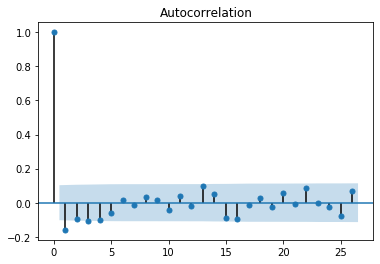

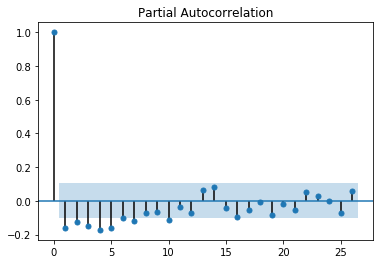

In [17]:
#Correlogram for the First Differences
plot_acf(aeroparque_diff)
plot_pacf(aeroparque_diff)

By looking at the correlogram, we see that we were able to make the series more stationary. Now, we are in a situation where we would be able to apply ARIMA processes. Still, it is worth checking that in the plot for the differences, there are sections with more volatility than others. This could signal that the assumptions for a constant mean and variance are violated in this series. This might occur because some of the periods with low volatility match with the peak months of the first coronavirus wave around the globe. 

Still, and for demonstration purposes, we will continue with ARIMA processes. Based on the correlogram, it might be appropriate to use a MA-1.

In [18]:
#ARIMA (0,1,1)
aero_arima011 = ARIMA(aeroparque_diff, order = (0,0,1)).fit(trend = "c")
print(aero_arima011.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  364
Model:                     ARMA(0, 1)   Log Likelihood                -880.909
Method:                       css-mle   S.D. of innovations              2.721
Date:                Sun, 08 Nov 2020   AIC                           1767.817
Time:                        17:40:22   BIC                           1779.509
Sample:                             0   HQIC                          1772.464
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0199      0.108      0.184      0.854      -0.192       0.232
ma.L1.y       -0.2423      0.069     -3.502      0.001      -0.378      -0.107
                                    Roots           

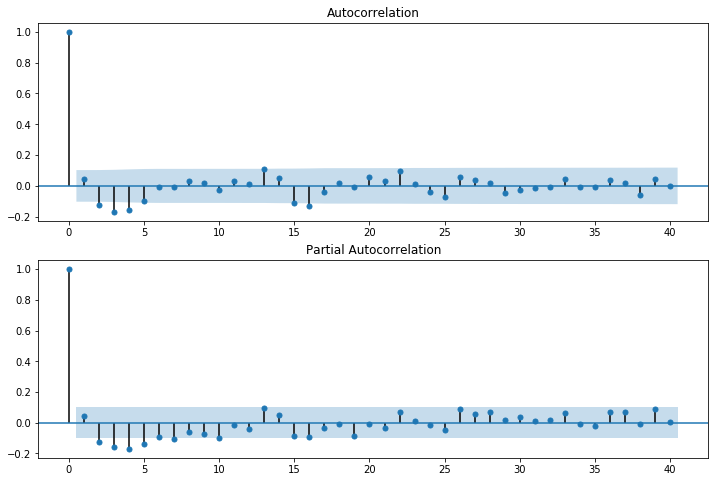

In [19]:
#Correlogram for (0,1,1)
resid_011 = aero_arima011.resid
fig2 = plt.figure(figsize=(12,8))
ax1 = fig2.add_subplot(211)
fig2 = plot_acf(resid_011, lags=40, ax=ax1)
ax2 = fig2.add_subplot(212)
fig2 = plot_pacf(resid_011, lags=40, ax=ax2)

In [20]:
r,q,p = sm.tsa.acf(resid_011.squeeze(), fft=True, qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

            AC          Q  Prob(>Q)
lag                                
1.0   0.043947   0.708801  0.399842
2.0  -0.122326   6.215742  0.044696
3.0  -0.167021  16.510537  0.000891
4.0  -0.159085  25.876201  0.000034
5.0  -0.096499  29.331902  0.000020
6.0  -0.010363  29.371862  0.000052
7.0  -0.006207  29.386238  0.000123
8.0   0.034482  29.831188  0.000226
9.0   0.015754  29.924324  0.000452
10.0 -0.028891  30.238453  0.000783
11.0  0.034371  30.684295  0.001236
12.0  0.014080  30.759325  0.002143
13.0  0.111369  35.467013  0.000717
14.0  0.049947  36.416609  0.000904
15.0 -0.108728  40.929370  0.000328
16.0 -0.129014  47.301422  0.000061
17.0 -0.041389  47.959111  0.000087
18.0  0.018304  48.088114  0.000146
19.0 -0.007271  48.108531  0.000247
20.0  0.060535  49.527731  0.000259
21.0  0.029395  49.863337  0.000381
22.0  0.093645  53.279416  0.000208
23.0  0.010581  53.323157  0.000331
24.0 -0.041130  53.986029  0.000428
25.0 -0.071156  55.975811  0.000366
26.0  0.059248  57.359413  0

In [21]:
r = sm.tsa.pacf(resid_011.squeeze())
data = np.c_[range(1,41), r[1:]]
table = pd.DataFrame(data, columns=['lag', "PAC"])
print(table.set_index('lag'))

           PAC
lag           
1.0   0.044068
2.0  -0.125187
3.0  -0.159600
4.0  -0.170524
5.0  -0.142081
6.0  -0.090328
7.0  -0.109729
8.0  -0.061457
9.0  -0.072216
10.0 -0.101742
11.0 -0.018490
12.0 -0.040052
13.0  0.093649
14.0  0.046925
15.0 -0.085315
16.0 -0.092368
17.0 -0.034592
18.0 -0.012044
19.0 -0.086425
20.0 -0.008032
21.0 -0.033643
22.0  0.070036
23.0  0.013408
24.0 -0.018097
25.0 -0.050428
26.0  0.087977
27.0  0.057527
28.0  0.066098
29.0  0.017841
30.0  0.037326
31.0  0.009046
32.0  0.018154
33.0  0.062788
34.0 -0.011343
35.0 -0.018800
36.0  0.067208
37.0  0.067591
38.0 -0.008950
39.0  0.087768
40.0  0.003110


In [23]:
#Normality of residuals
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sm.stats.stattools.jarque_bera(resid_011)
jb = zip(name, test)
for i in jb:
    print(i)
stats.normaltest(resid_011)

('Jarque-Bera', 6.068363708413016)
('Chi^2 two-tail prob.', 0.048114011052878415)
('Skew', 0.05367635724300165)
('Kurtosis', 3.6233676985174026)


NormaltestResult(statistic=4.714309155243273, pvalue=0.09468927120844514)

(array([ 2.,  3., 17., 68., 91., 96., 64., 15.,  6.,  2.]),
 array([-9.83471445, -7.87354624, -5.91237803, -3.95120983, -1.99004162,
        -0.02887342,  1.93229479,  3.89346299,  5.8546312 ,  7.8157994 ,
         9.77696761]),
 <a list of 10 Patch objects>)

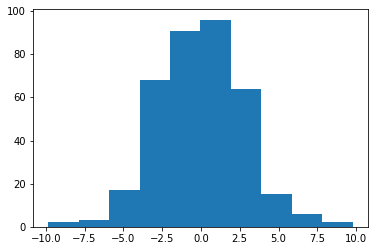

In [24]:
fig3 = plt.hist(resid_011)
fig3

Conclusions:

Based on the previous evidence, we can conclude that the process IMA(1,1) is not that good since: 

1- Both correlograms show that there is still room for improvement, either with an MA or AR process. 

2- The residuals are not normal based on two tests, even if graphically they appear to have some sort of normal behaviour.

Thus, it might be recommended to do another ARIMA process to further improve the model. Let's do it quickly


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  364
Model:                     ARMA(1, 2)   Log Likelihood                -857.519
Method:                       css-mle   S.D. of innovations              2.549
Date:                Sun, 08 Nov 2020   AIC                           1723.038
Time:                        17:40:58   BIC                           1738.626
Sample:                             0   HQIC                          1729.233
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4832      0.090      5.354      0.000       0.306       0.660
ma.L1.y       -0.8069      0.095     -8.523      0.000      -0.992      -0.621
ma.L2.y       -0.0925      0.078     -1.190      0.2

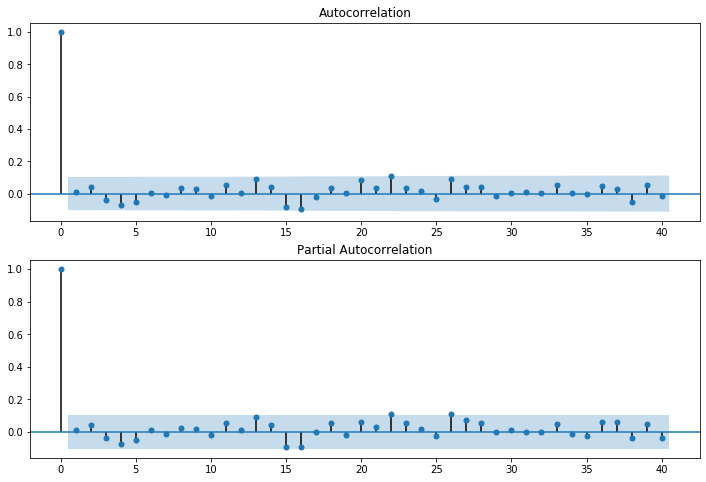

In [25]:
#ARIMA (1,1,2)
aero_arima112 = ARIMA(aeroparque_diff, order = (1,0,2)).fit(trend = "nc")
print(aero_arima112.summary())

resid_112 = aero_arima112.resid
fig5 = plt.figure(figsize=(12,8))
ax11 = fig5.add_subplot(211)
fig5 = plot_acf(resid_112, lags=40, ax=ax11)
ax21 = fig5.add_subplot(212)
fig5 = plot_pacf(resid_112, lags=40, ax=ax21)



r2,q2,p2 = sm.tsa.acf(resid_112.squeeze(), fft=True, qstat=True)
data2 = np.c_[range(1,41), r2[1:], q2, p2]
table2 = pd.DataFrame(data2, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table2.set_index('lag'))

r2 = sm.tsa.pacf(resid_112.squeeze())
data2 = np.c_[range(1,41), r2[1:]]
table2 = pd.DataFrame(data2, columns=['lag', "PAC"])
print(table2.set_index('lag'))


name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sm.stats.stattools.jarque_bera(resid_112)
jb = zip(name, test)
for i in jb:
    print(i)
print(stats.normaltest(resid_112))




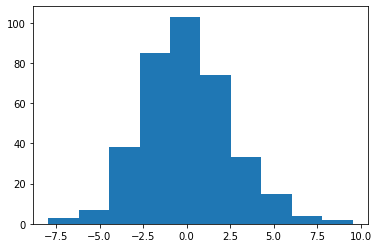

In [26]:
fig6 = plt.hist(resid_112)

Based on the ARIMA(1,1,2), we still find present some of the issues of the previous model. In particular, the residuals aren't normal yet. On the other hand, the correlogram improved but at the cost of being not significant.

Therefore, an ARIMA(1,1,2) might not be the most appropriate for the data. In order to find the appropriate model, it is suggested to apply different orders of ARIMA, and even to increase the differencing order. 

Still, it might be better to apply other time series models. Let's give a quick try to cointegration.


In [27]:
#Cointegration
city2 = temperatures[temperatures["city"] == city_list[1]]
city2 = city2.sort_values(by = "date")
sm.tsa.stattools.coint(aeroparque_ori["tmax"], city2["tmax"], trend = "c")

(-14.80049861697479,
 1.8251019710582068e-26,
 array([-3.92678068, -3.35296748, -3.05612218]))

With a p-value very close to 0, we might have found out that Cointegration processes work very well for this dataset. 

Yet, to truly verify this relation, we might need to dig a little bit further at other aspects such as the distance between the two locations, but let's leave it like that for the moment.

Now, to close it out, let's store all the information for the ARIMA processes in a new Class object.

In [28]:
class ARIMA_temp:
    import pandas as pd
    import seaborn as sns
    import statsmodels.api as sm
    import numpy as np
    import matplotlib.pyplot as plt
    from statsmodels.graphics.tsaplots import plot_acf
    from statsmodels.graphics.tsaplots import plot_pacf
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.tsa.stattools import kpss
    from statsmodels.tsa.arima_model import ARIMA
    from scipy import stats
    
    
    def __init__(self, city, data):
        self.name = str(city)
        self.data = data[data["city"] == self.name].sort_values(by = "date")
    def ori_graph(self):
        aerograph, aero_ax = plt.subplots(1, facecolor = "deepskyblue")
        sns.relplot(x="date", y="tmax", kind="line", ci = "sd", linewidth = 10, data=self.data, ax = aero_ax)
        aerograph.set_figheight(80)
        aerograph.set_figwidth(80)
        aero_ax.set_title("{}'S TEMPERATURE FROM OCT 2019 TO OCT 2020".format(self.name), 
                  fontsize = 80,
                 color = "darkgoldenrod")
        aero_ax.set_ylabel("Temperature in Celsius",
                  fontsize = 60,
                  color = "darkgoldenrod")
        aero_ax.set_xlabel("Date",
                  fontsize = 60,
                  color = "darkgoldenrod")
        aero_ax.tick_params(axis='y', which='major', colors = "darkgoldenrod", labelsize=30)
        aero_ax.set_xticks([0,11,41,72,103,132,163,193,224,254,285,316,346])
        tick_locations = [0,11,41,72,103,132,163,193,224,254,285,316,346]
        for i in tick_locations:
            aero_ax.axvline(x=i, lw = 0.5, alpha = 0.5, color = "k")
        aero_ax.tick_params(axis='x', which='major', labelsize=30, colors = "darkgoldenrod")
        for side in aero_ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
            aero_ax.spines[side].set_linewidth(5)
        aerograph.autofmt_xdate()
        self.graph = aerograph
    def adf_test(self):
        def adf_test(timeseries):
            print ('Results of Dickey-Fuller Test:')
            dftest = adfuller(timeseries, autolag='AIC', regression = "c")
            dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
            for key,value in dftest[4].items():
               dfoutput['Critical Value (%s)'%key] = value
            return dfoutput
        self.adf = adf_test(self.data["tmax"])
    def kpss_test(self):
        def kpss_test(timeseries):
            print ('Results of KPSS Test:')
            kpsstest = kpss(timeseries, regression='c', lags='auto')
            kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
            for key,value in kpsstest[3].items():
                kpss_output['Critical Value (%s)'%key] = value
            return kpss_output
        self.kpss = kpss_test(self.data["tmax"])
    def get_diff(self):
        self.diff = np.diff(self.data["tmax"], n =1)
    def dif_pacf(self):
        return plot_pacf(self.diff)
    def dif_acf(self):
        return plot_acf(self.diff)
    def do_ARIMA(self, AR, MA, trend_opt = "nc"):
        aero_arima112 = ARIMA(self.diff, order = (AR,0,MA)).fit(trend = trend_opt)
        #print(aero_arima112.summary())
        self.arima = aero_arima112.summary()
        
        resid_112 = aero_arima112.resid
        fig5 = plt.figure(figsize=(12,8))
        ax11 = fig5.add_subplot(211)
        fig5 = plot_acf(resid_112, lags=40, ax=ax11)
        ax21 = fig5.add_subplot(212)
        fig5 = plot_pacf(resid_112, lags=40, ax=ax21)

        self.arima_correlogram = fig5

        r2,q2,p2 = sm.tsa.acf(resid_112.squeeze(), fft=True, qstat=True)
        data2 = np.c_[range(1,41), r2[1:], q2, p2]
        table2 = pd.DataFrame(data2, columns=['lag', "AC", "Q", "Prob(>Q)"])
        #print(table2.set_index('lag'))

        self.arima_acf = table2.set_index('lag')
        
        r2 = sm.tsa.pacf(resid_112.squeeze())
        data3 = np.c_[range(1,41), r2[1:]]
        table3 = pd.DataFrame(data3, columns=['lag', "PAC"])
        #print(table3.set_index('lag'))
        
        self.arima_pacf = table3.set_index('lag')

        name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
        test = sm.stats.stattools.jarque_bera(resid_112)
        jb = zip(name, test)
        #for i in jb:
            #print(i)
        
        self.jb = jb
        
        self.normal = stats.normaltest(resid_112)

        fig6 = plt.hist(resid_112)
        
        self.resid_hist = fig6
        
        return "ARIMA HAS BEEN DONE FOR AR {} AND MA {}, PLEASE LOOK AT THE APPROPRIATE ATTRIBUTES".format(AR, MA)
    

CHEPES
       day  month  year  tmax  tmin    city        date
24923   21     10  2019  30.5  10.0  CHEPES  2019-10-21
24875   22     10  2019  27.5  14.0  CHEPES  2019-10-22
24826   23     10  2019  28.0  12.0  CHEPES  2019-10-23
24768   24     10  2019  31.0  17.0  CHEPES  2019-10-24
24685   25     10  2019  32.0  19.0  CHEPES  2019-10-25
...    ...    ...   ...   ...   ...     ...         ...
392     15     10  2020  29.0  14.0  CHEPES  2020-10-15
301     16     10  2020  32.5  17.5  CHEPES  2020-10-16
202     17     10  2020  36.5  21.0  CHEPES  2020-10-17
108     18     10  2020  39.5  25.0  CHEPES  2020-10-18
13      19     10  2020  33.5  19.5  CHEPES  2020-10-19

[365 rows x 7 columns]
Results of Dickey-Fuller Test:


Test Statistic                  -1.842182
p-value                          0.359730
#Lags Used                       7.000000
Number of Observations Used    357.000000
Critical Value (1%)             -3.448801
Critical Value (5%)             -2.869670
Critical Value (10%)            -2.571101
dtype: float64

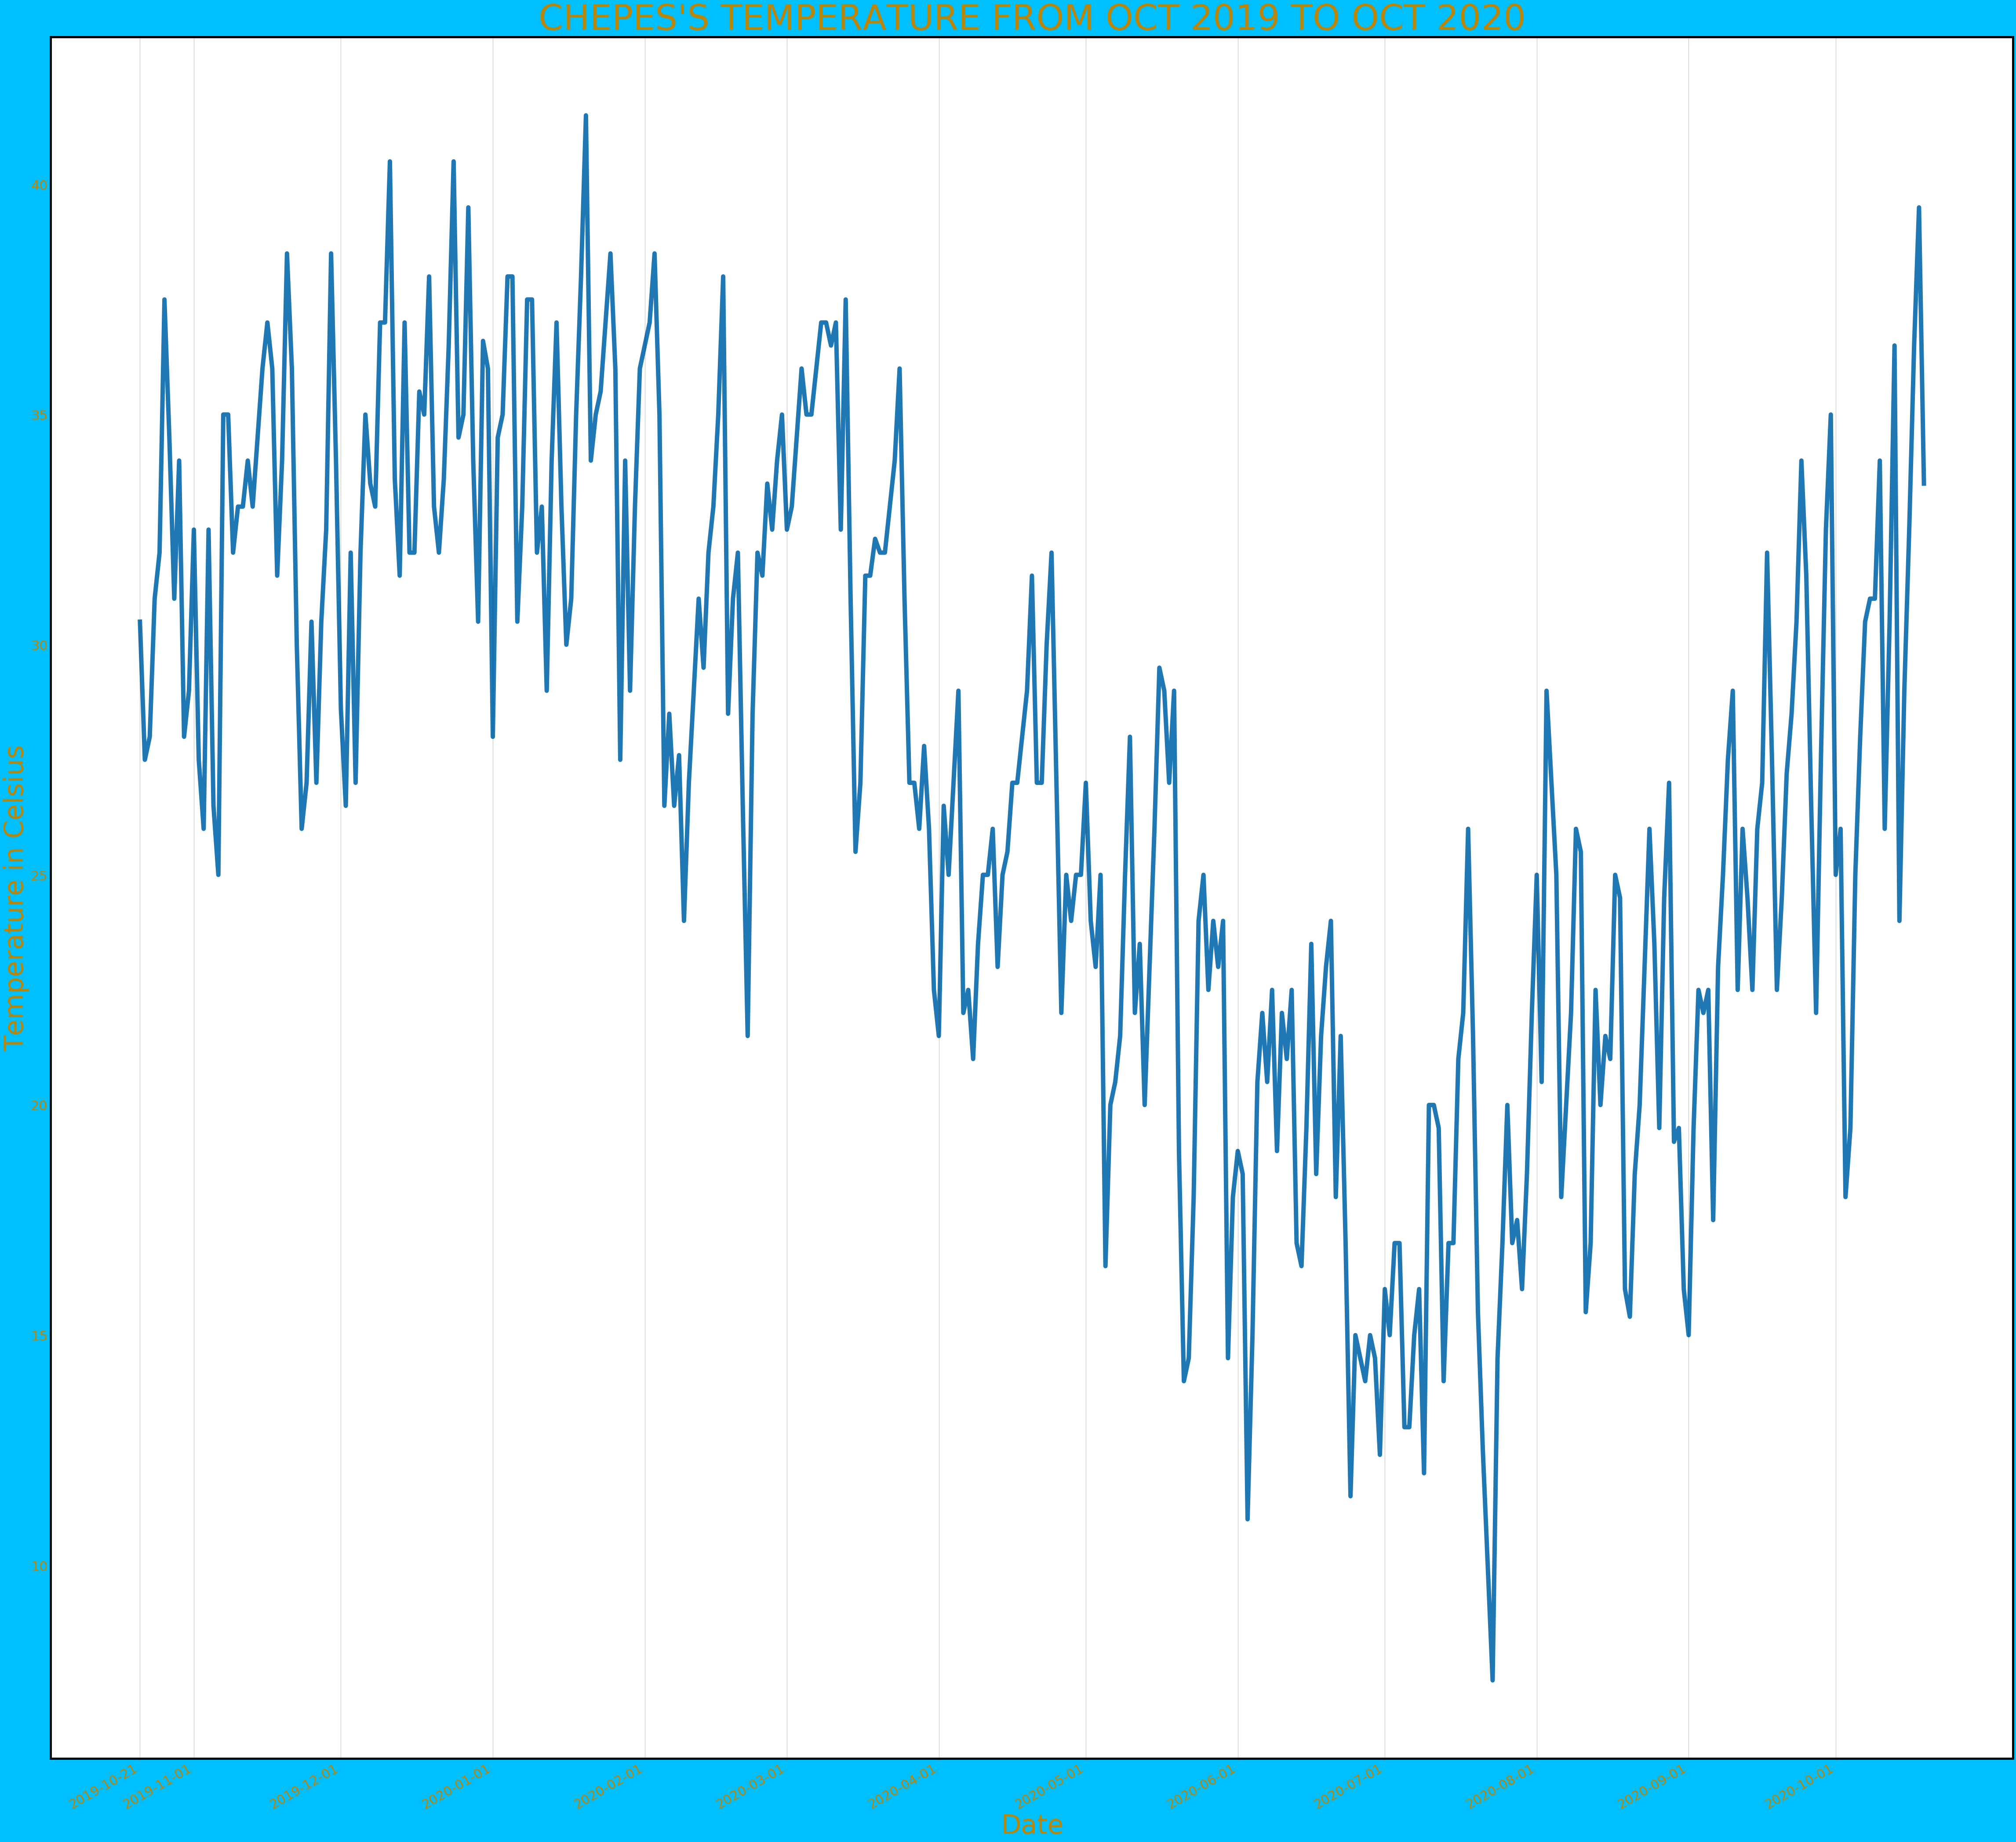

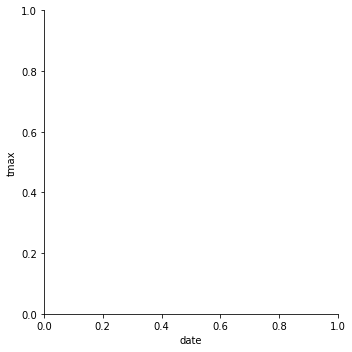

In [29]:
#Testing that the object works
chepes = ARIMA_temp("CHEPES", temperatures)
print(chepes.name)
print(chepes.data)
chepes.ori_graph()
chepes.graph
chepes.adf_test()
chepes.adf

In [30]:
chepes.get_diff()

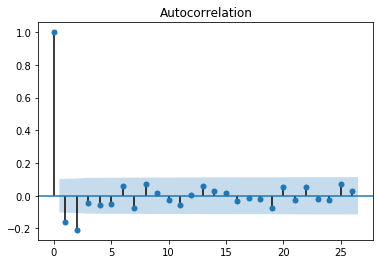

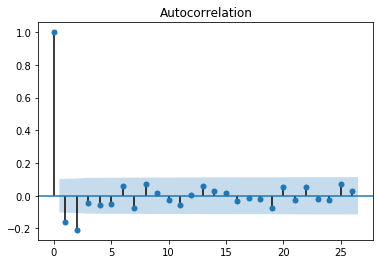

In [31]:
chepes.dif_acf()

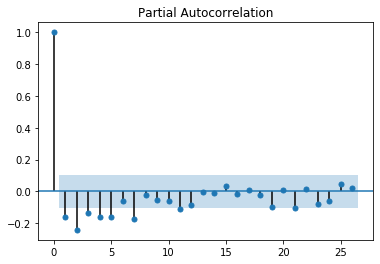

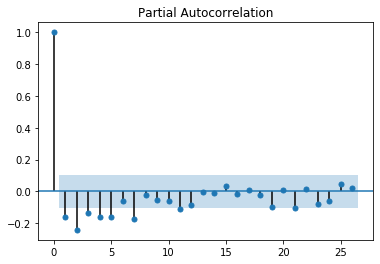

In [32]:
chepes.dif_pacf()

'ARIMA HAS BEEN DONE FOR AR 0 AND MA 2, PLEASE LOOK AT THE APPROPRIATE ATTRIBUTES'

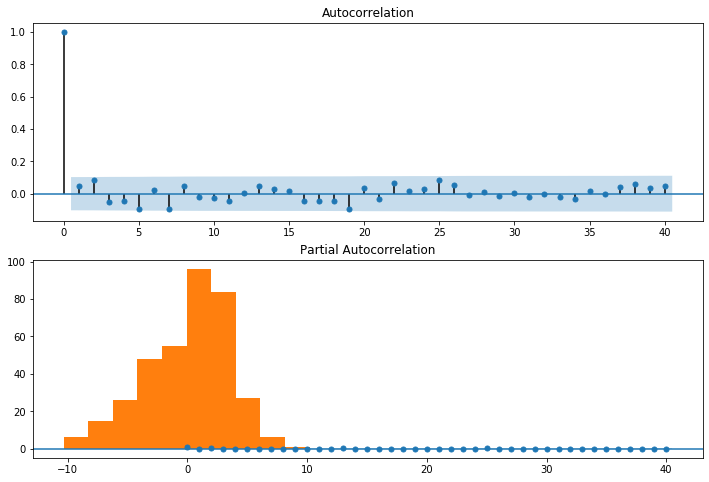

In [33]:
chepes.do_ARIMA(0,2)

In [34]:
chepes.normal

NormaltestResult(statistic=12.106821632817857, pvalue=0.0023498334717809103)